# Amazon Alexa Review Sentiment Analysis: pos, neu, neg

- Sentiment analysis on amazon product's review  - Amazon Echo White

In [ ]:
# add gitinore 
# download and extract data from kaggle or json file..
# don't track json, zip, csv, DS_store file

In [3]:
# installing the kaggle library to fetch the dataset from kaggle 

%pip install kaggle 

# configuring 
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle / 
!chmod 600 ~/.kaggle/kaggle.json

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
cp: /kaggle.json: Read-only file system
cp: /Users/rt/.kaggle is a directory (not copied).


In [4]:
# API to fetch the dataset from kaggle:
! kaggle datasets download -d sid321axn/amazon-alexa-reviews

/Users/rt/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Dataset URL: https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews
License(s): other
  0%|                                                | 0.00/164k [00:00<?, ?B/s]
100%|█████████████████████████████████████████| 164k/164k [00:00<00:00, 264MB/s]


In [5]:
# extracting the dataset we just downloaded
from zipfile import ZipFile
dataset_path = "./amazon-alexa-reviews.zip"
with ZipFile(dataset_path, "r") as zip:
    zip.extractall(".")
    print("Dataset extracted successfully")

Dataset extracted successfully


### Importing required libraries: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle 
import re
!pip install wordcloud
!pip install xgboost

from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


[nltk_data] Downloading package stopwords to /Users/rt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis: 

In [5]:
# load the data: 
data = pd.read_csv(r"./amazon_alexa.tsv", delimiter = '\t', quoting=3)
print("Database shape", data.shape)

Database shape (3150, 5)


In [6]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [9]:
data.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [14]:
# check the data types of each columns present in the dataset. 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [11]:
# checking if there are any null values in the dataset. 
data.isna().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

There is one record with 'verified_reviews' null value.

In [17]:
# check out which exactly one row has a verified_reviews null (N/A) value. 
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


We're dropping this record since it's only one data record, it may not have that much impact on the result of the our sentiment analysis.

In [18]:
data.dropna(inplace=True)
data.shape

(3149, 5)

In [19]:
# creating and adding a new variable /new column called 'length' which denotes the length of the string in verified reviews. 

data['length'] = data['verified_reviews'].apply(len)
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


## Analyzing the rating column: 
- Column refers to the rating of the variation given by user

In [27]:
data['rating'].value_counts(), data['feedback'].value_counts()

(rating
 5    2286
 4     455
 1     161
 3     152
 2      95
 Name: count, dtype: int64,
 feedback
 1    2893
 0     256
 Name: count, dtype: int64)

Here, most of the rating are 5 stars rating

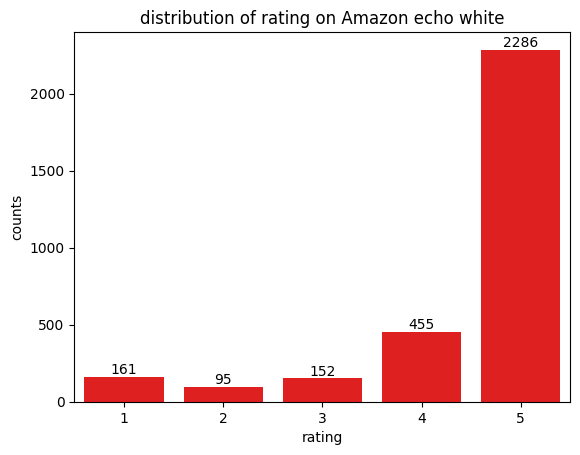

In [67]:
# plot the rating in the plot: 
ax=sns.countplot(x='rating', data=data, color='red')
plt.title("distribution of rating on Amazon echo white")
plt.xlabel('rating')
plt.ylabel('counts')
ax.bar_label(ax.containers[0])
plt.show()

Text(0.5, 1.0, 'distribution of rating on amazon echo white using pie charts')

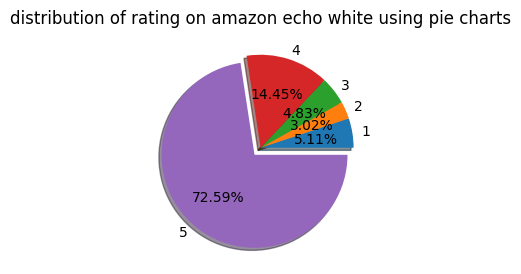

In [ ]:
plt.figure(figsize=(3,4))
explode=(0.1,0,0,0,0.1)
gb=data.groupby("rating").agg({"rating":"count"})
plt.pie(gb['rating'], labels=gb.index, autopct='%1.2f%%', explode=explode, shadow=True)
plt.title("distribution of rating on amazon echo white using pie charts")


## Analyzing the feedback column: 

In [85]:
# checking counts of each feedback values: 
data["feedback"].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

There are two distinct feeedback values. 

In [ ]:
# extracting the 'verified_reviews' value for one record with feedback = 0, =1. 
# what does feedback ==1 indicate? let's look at its correspoding verified reviews

review_1 = data[data['feedback']==1].iloc[1]['verified_reviews']
review_0 = data[data['feedback']==0].iloc[1]['verified_reviews']

print(review_0)
print(review_1)

Sound is terrible if u want good music too get a bose
Loved it!


From above results, we can see that feedback **0 is negative review** and **1 is positive review.**

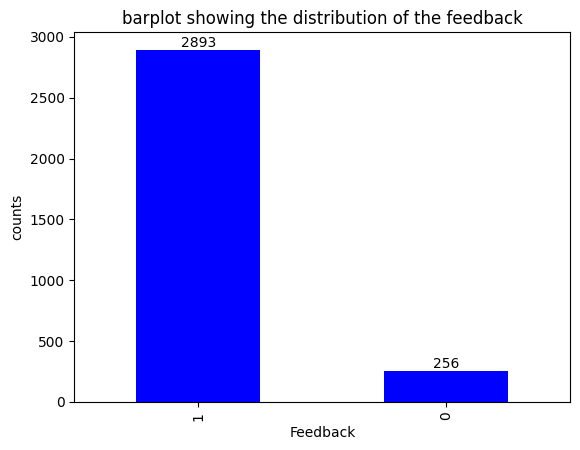

In [87]:
# let's plot the feedback value counts in a bar graph. 
# bar grpah to visualize the total counts of each feedback

ax = data['feedback'].value_counts().plot.bar(color='blue')
plt.title("barplot showing the distribution of the feedback")
plt.xlabel('Feedback')
plt.ylabel('counts')
ax.bar_label(ax.containers[0])
plt.show()

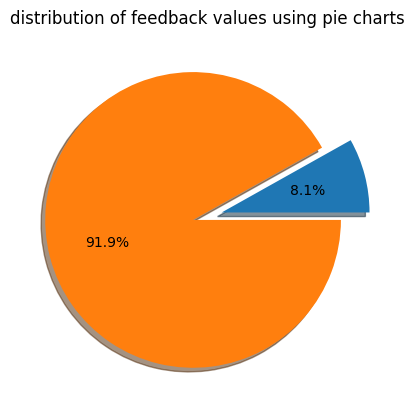

In [100]:
explode= (0.1,0.1)
gb = data.groupby("feedback").agg({'feedback':'count'})
plt.pie(gb['feedback'], explode=explode, autopct='%1.1f%%',shadow=True)
plt.title("distribution of feedback values using pie charts")
plt.show()